The below code focuses on basic text data cleaning, vizualization and model building for disaster and non-disaster tweets. 

This kernel includes codes and ideas from the kernel below, if this kernel helps you, please upvote their work as well.
https://www.kaggle.com/faressayah/cnns-rnns-for-nlp-tasks

In [2]:
import pandas as pd
import numpy as np

In [3]:
test=pd.read_csv('../input/nlp-getting-started/test.csv')
train=pd.read_csv('../input/nlp-getting-started/train.csv')

In [4]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
train.shape,test.shape

((7613, 5), (3263, 4))

In [7]:
print('Training Set Memory Usage = {:.2f} MB'.format(train.memory_usage().sum() / 1024**2))
print('Testing Set Memory Usage = {:.2f} MB'.format(test.memory_usage().sum() / 1024**2))

Training Set Memory Usage = 0.29 MB
Testing Set Memory Usage = 0.10 MB


Check for the number of categorical and continuous columns in each of the dataset

In [8]:
cols_train = train.columns
num_cols_train = train._get_numeric_data().columns
a=list(set(cols_train) - set(num_cols_train))
print('No of Categorical columns in Train :',len(a),"\n",a)
print("No of Continuous columns in Train:",len(train._get_numeric_data().columns))
print(train._get_numeric_data().columns)
cols_test = test.columns
num_cols_test = test._get_numeric_data().columns
a=list(set(cols_test) - set(num_cols_test))
print('No of Categorical columns in Test :',len(a),"\n",a)
print("No of Continuous columns in Test:",len(test._get_numeric_data().columns))
print(test._get_numeric_data().columns)

No of Categorical columns in Train : 3 
 ['keyword', 'text', 'location']
No of Continuous columns in Train: 2
Index(['id', 'target'], dtype='object')
No of Categorical columns in Test : 3 
 ['keyword', 'text', 'location']
No of Continuous columns in Test: 1
Index(['id'], dtype='object')


In [9]:
train.info(),test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


(None, None)

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import nltk
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import string
import re

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Remove URLs, Emojis, HTML tags and Punctuation from the text.

In [11]:
import re
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)
train['text']=train['text'].apply(lambda x : remove_URL(x))
test['text']=test['text'].apply(lambda x : remove_URL(x))

In [15]:
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)
train.text=train.text.apply(lambda x: deEmojify(x))
test.text=test.text.apply(lambda x: deEmojify(x))
# Reference: https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python

In [16]:
#Remove HTML tags
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
train.text=train.text.apply(lambda x : remove_html(x))
test.text=test.text.apply(lambda x : remove_html(x))

In [17]:
# function for removing punctuations
def remove_punctuation(text):
    no_punct=[words for words in text if words not in string.punctuation]
    words_wo_punct=''.join(no_punct)
    return words_wo_punct
train.text=train.text.apply(lambda x: remove_punctuation(x))
test.text=test.text.apply(lambda x: remove_punctuation(x))

Divide Non-Disaster tweets and Disaster tweets for further Visualization 

In [19]:
disaster_words=train[train.target==1]['text']
non_dis_wrds=train[train.target==0]['text']

In [20]:
disaster_words ,non_dis_wrds

(0       Our Deeds are the Reason of this earthquake Ma...
 1                   Forest fire near La Ronge Sask Canada
 2       All residents asked to shelter in place are be...
 3       13000 people receive wildfires evacuation orde...
 4       Just got sent this photo from Ruby Alaska as s...
                               ...                        
 7608    Two giant cranes holding a bridge collapse int...
 7609    ariaahrary TheTawniest The out of control wild...
 7610                M194 0104 UTC5km S of Volcano Hawaii 
 7611    Police investigating after an ebike collided w...
 7612    The Latest More Homes Razed by Northern Califo...
 Name: text, Length: 3271, dtype: object,
 15                                           Whats up man
 16                                          I love fruits
 17                                       Summer is lovely
 18                                      My car is so fast
 19                                 What a goooooooaaaaaal
              

In [21]:
def plot_wordcloud(text):
    wordcloud = WordCloud(background_color = 'black',
                         max_words = 3000,
                         width=1600,
                         height=800).generate(text)
    plt.clf()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

****DISASTER WORD WORDCLOUD****

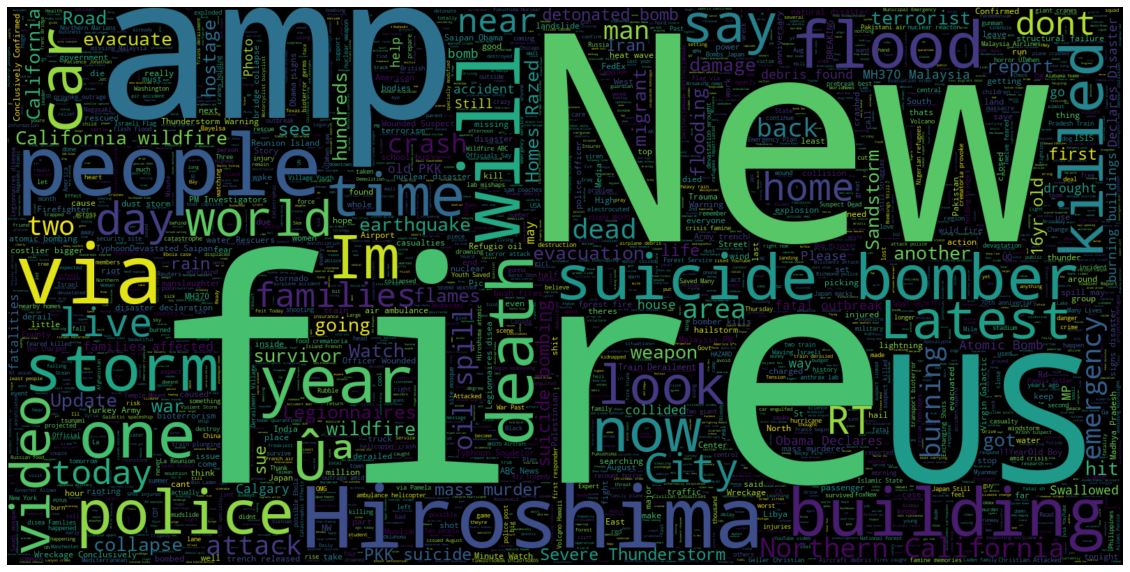

In [22]:
plt.figure(figsize=(20,18))
plot_wordcloud(' '.join(disaster_words))

> **NON DISASTER WORDCLOUD**

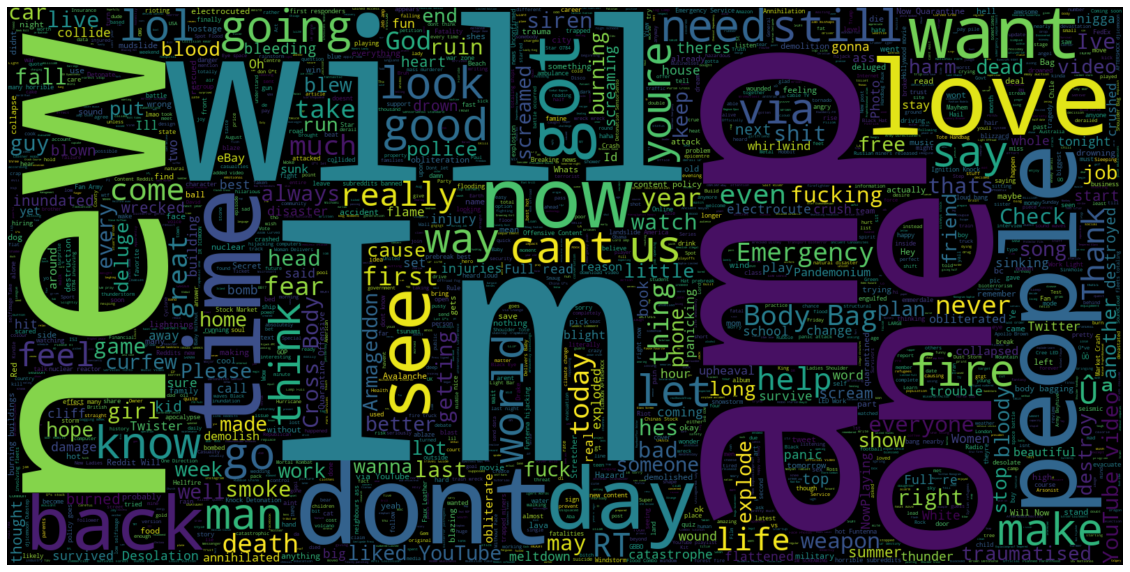

In [23]:
plt.figure(figsize=(20,18))
plot_wordcloud(' '.join(non_dis_wrds))

In [24]:
train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

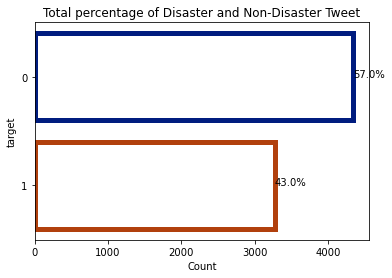

In [25]:
total = len(train['target'])
ax = sns.countplot(y="target", data=train, facecolor=(0, 0, 0, 0),
                   linewidth=5,
                   edgecolor=sns.color_palette("dark", 3))
ax.set_title('Total percentage of Disaster and Non-Disaster Tweet')
plt.xlabel('Count')

total = len(train['target'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

plt.show()

In the above count plot visualization it can be seen that there are more non-disaster tweets (0) than disaster tweets (1).

In [26]:
 def basic_clean(text):
        wnl = nltk.stem.WordNetLemmatizer()
        stopwords = nltk.corpus.stopwords.words('english')
        words = re.sub(r'[^\w\s]', '', text).split()
        return [wnl.lemmatize(word) for word in words if word not in stopwords]
"""
A simple function to clean up the data. All the words that
are not designated as a stop word is then lemmatized after
encoding and basic regex parsing are performed.
"""

'\nA simple function to clean up the data. All the words that\nare not designated as a stop word is then lemmatized after\nencoding and basic regex parsing are performed.\n'

In [27]:
dw = basic_clean(''.join(str(train[train.target==1]['text'].tolist())))
dw[:20]

['Our',
 'Deeds',
 'Reason',
 'earthquake',
 'May',
 'ALLAH',
 'Forgive',
 'u',
 'Forest',
 'fire',
 'near',
 'La',
 'Ronge',
 'Sask',
 'Canada',
 'All',
 'resident',
 'asked',
 'shelter',
 'place']

In [28]:
ndw = basic_clean(''.join(str(train[train.target==0]['text'].tolist())))
ndw[:20] 

['Whats',
 'man',
 'I',
 'love',
 'fruit',
 'Summer',
 'lovely',
 'My',
 'car',
 'fast',
 'What',
 'goooooooaaaaaal',
 'ridiculous',
 'London',
 'cool',
 'Love',
 'skiing',
 'What',
 'wonderful',
 'day']

# N-Gram Analysis
In the fields of computational linguistics and probability, an n-gram is a contiguous sequence of n items from a given sample of text or speech. The items can be phonemes, syllables, letters, words or base pairs according to the application. The n-grams typically are collected from a text or speech corpus. When the items are words, n-grams may also be called shingles

## N-gram Analysis - Unigram, Bigram and Trigram
### N-gram for Disaster Words

In [29]:
dw_unigram_series = (pd.Series(nltk.ngrams(dw, 1)).value_counts())[:20]

Text(0.5, 0, '# of Occurances')

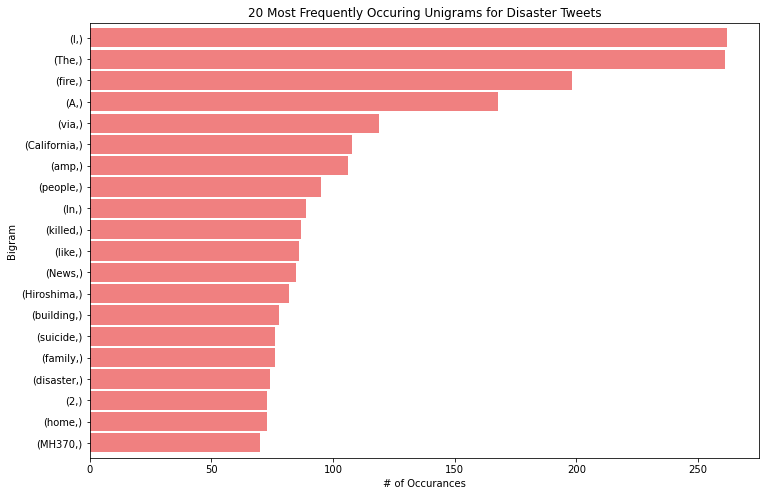

In [30]:
dw_unigram_series.sort_values().plot.barh(color='lightcoral', width=.9, figsize=(12, 8))
plt.title('20 Most Frequently Occuring Unigrams for Disaster Tweets')
plt.ylabel('Bigram')
plt.xlabel('# of Occurances')

### Disaster Words - Bigram

In [31]:
dw_bigrams_series = (pd.Series(nltk.ngrams(dw, 2)).value_counts())[:20]

Text(0.5, 0, '# of Occurances')

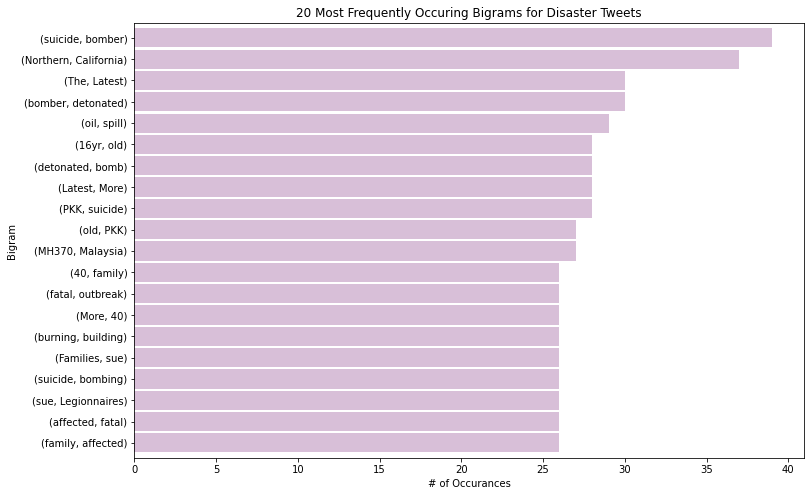

In [32]:
dw_bigrams_series.sort_values().plot.barh(color='thistle', width=.9, figsize=(12, 8))
plt.title('20 Most Frequently Occuring Bigrams for Disaster Tweets')
plt.ylabel('Bigram')
plt.xlabel('# of Occurances')

### Disaster Set Words - Trigram

Text(0.5, 0, '# of Occurances')

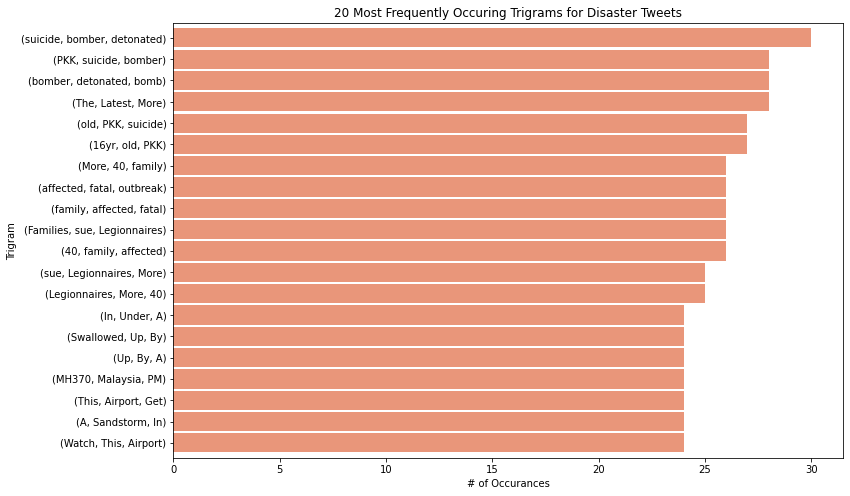

In [33]:
dw_trigrams_series = (pd.Series(nltk.ngrams(dw, 3)).value_counts())[:20]
dw_trigrams_series.sort_values().plot.barh(color='darksalmon', width=.9, figsize=(12, 8))
plt.title('20 Most Frequently Occuring Trigrams for Disaster Tweets')
plt.ylabel('Trigram')
plt.xlabel('# of Occurances')

### N-gram for Non-Disaster Words


Text(0.5, 0, '# of Occurances')

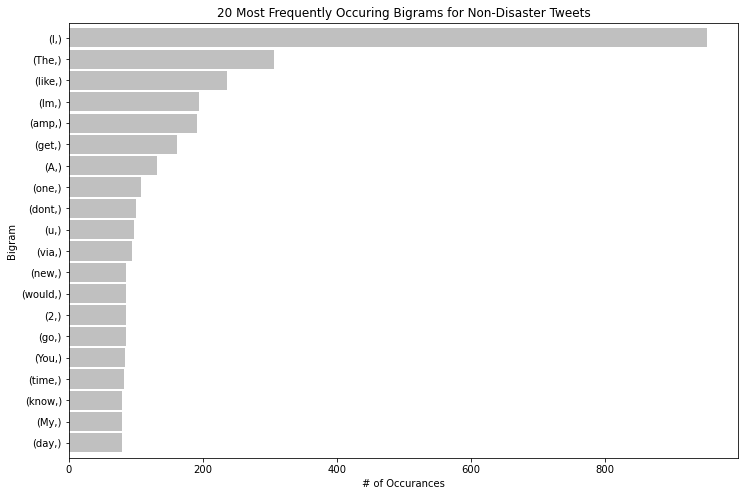

In [34]:
ndw_unigram_series = (pd.Series(nltk.ngrams(ndw, 1)).value_counts())[:20]
ndw_unigram_series.sort_values().plot.barh(color='silver', width=.9, figsize=(12, 8))
plt.title('20 Most Frequently Occuring Bigrams for Non-Disaster Tweets')
plt.ylabel('Bigram')
plt.xlabel('# of Occurances')


### Non Disaster Words - Bigram

In [35]:
ndw_bigrams_series = (pd.Series(nltk.ngrams(ndw, 2)).value_counts())[:20]

Text(0.5, 0, '# of Occurances')

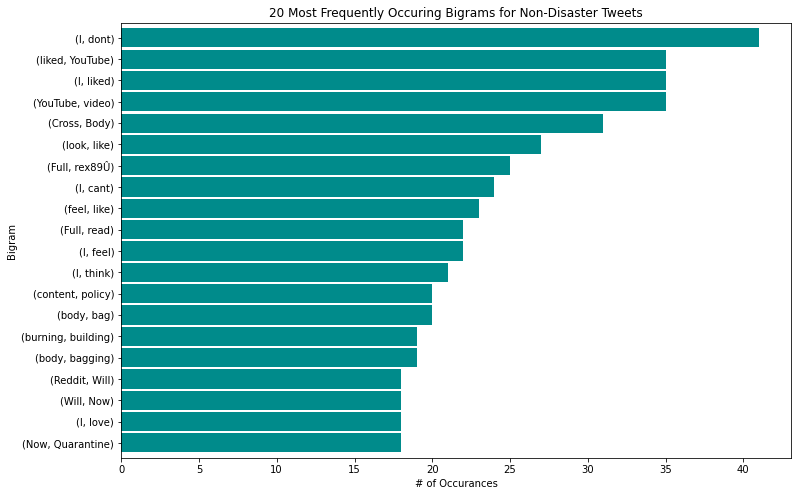

In [36]:
ndw_bigrams_series.sort_values().plot.barh(color='darkcyan', width=.9, figsize=(12, 8))
plt.title('20 Most Frequently Occuring Bigrams for Non-Disaster Tweets')
plt.ylabel('Bigram')
plt.xlabel('# of Occurances')

### Non Disaster Words - Trigram

Text(0.5, 0, '# of Occurances')

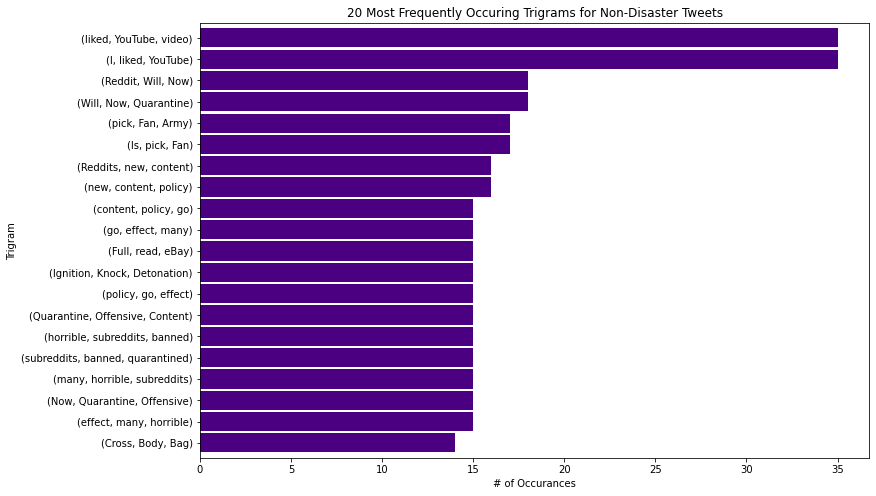

In [37]:
ndw_trigrams_series = (pd.Series(nltk.ngrams(ndw, 3)).value_counts())[:20]
ndw_trigrams_series.sort_values().plot.barh(color='indigo', width=.9, figsize=(12, 8))
plt.title('20 Most Frequently Occuring Trigrams for Non-Disaster Tweets')
plt.ylabel('Trigram')
plt.xlabel('# of Occurances')

## **Machine Learning Models**

In [40]:
X=train.text
Y=train.target

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer # for bag of words 
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC

### Support Vector Classifier

Accuracy of SVC: 80.34150612959719%

 Confusion Matrix: 
 [[1145  193]
 [ 256  690]]

 Classification Report: 
               precision    recall  f1-score   support

           0       0.82      0.86      0.84      1338
           1       0.78      0.73      0.75       946

    accuracy                           0.80      2284
   macro avg       0.80      0.79      0.80      2284
weighted avg       0.80      0.80      0.80      2284


Confusion Matrix Plot: 


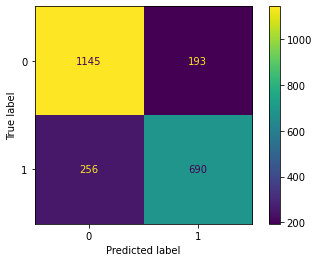

In [42]:
x_train,x_test,y_train,y_test = train_test_split(X,Y, test_size=0.3, random_state=0)

pipe = Pipeline([('vect', CountVectorizer()), # for bag of words
                 ('tfidf', TfidfTransformer()),
                 ('model', LinearSVC())])

model_svc = pipe.fit(x_train, y_train)
prediction_svc = model_svc.predict(x_test)
print("Accuracy of SVC: {}%".format(accuracy_score(y_test, prediction_svc)*100,2))
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report,plot_confusion_matrix
print("\n Confusion Matrix: \n",confusion_matrix(y_test, prediction_svc))
print("\n Classification Report: \n",classification_report(y_test, prediction_svc))
print("\nConfusion Matrix Plot: \n",plot_confusion_matrix(model_svc,x_test,y_test))

### Logistic Classifier

Accuracy of Logistic Regression: 80.34150612959719%

 Confusion Matrix: 
 [[1145  193]
 [ 256  690]]

 Classification Report: 
               precision    recall  f1-score   support

           0       0.82      0.86      0.84      1338
           1       0.78      0.73      0.75       946

    accuracy                           0.80      2284
   macro avg       0.80      0.79      0.80      2284
weighted avg       0.80      0.80      0.80      2284


Confusion Matrix Plot: 


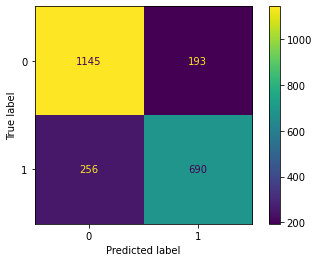

In [43]:
from sklearn.linear_model import LogisticRegression
fpipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

model_lr = pipe.fit(x_train, y_train)
prediction_lr = model_lr.predict(x_test)
print("Accuracy of Logistic Regression: {}%".format(accuracy_score(y_test, prediction_lr)*100,2))
print("\n Confusion Matrix: \n",confusion_matrix(y_test, prediction_lr))
print("\n Classification Report: \n",classification_report(y_test, prediction_lr))
print("\nConfusion Matrix Plot: \n",plot_confusion_matrix(model_lr,x_test,y_test))


### KNN Classifier

accuracy: 77.63%

 Confusion Matrix: 
 [[1140  198]
 [ 313  633]]

 Classification Report: 
               precision    recall  f1-score   support

           0       0.78      0.85      0.82      1338
           1       0.76      0.67      0.71       946

    accuracy                           0.78      2284
   macro avg       0.77      0.76      0.76      2284
weighted avg       0.78      0.78      0.77      2284


Confusion Matrix Plot: 


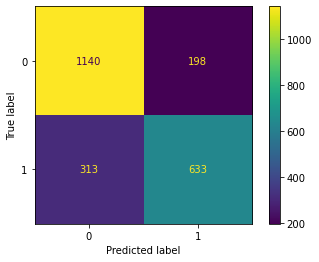

In [44]:
from sklearn.neighbors import KNeighborsClassifier
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', KNeighborsClassifier(n_neighbors = 10,weights = 'distance',algorithm = 'brute'))])

model = pipe.fit(x_train, y_train)
prediction = model.predict(x_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print("\n Confusion Matrix: \n",confusion_matrix(y_test, prediction))
print("\n Classification Report: \n",classification_report(y_test, prediction))
print("\nConfusion Matrix Plot: \n",plot_confusion_matrix(model,x_test,y_test))

In [45]:
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling1D, Dropout, SpatialDropout1D
from tensorflow.keras.layers import LSTM, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


def plot_loss_evaluation(r):
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.plot(r.history['loss'], label='loss')
    plt.plot(r.history['val_loss'], label='val_loss')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(r.history['accuracy'], label='accuracy')
    plt.plot(r.history['val_accuracy'], label='val_acc')
    plt.legend()
    
    plt.title('Training and Loss fuction evolution')
    
def evaluate(model, X_train, X_test, y_train, y_test):
    y_pred_train = np.round(model.predict(X_train))
    y_pred_test = np.round(model.predict(X_test))
    
    print("Training Data")
    print(confusion_matrix(y_train, y_pred_train))
    print(classification_report(y_train, y_pred_train))
    print(f"Accuracy score: {accuracy_score(y_train, y_pred_train) * 100:.2f}%")
    
    print("Testing Data")
    print(confusion_matrix(y_test, y_pred_test))
    print(classification_report(y_test, y_pred_test))
    print(f"Accuracy score: {accuracy_score(y_test, y_pred_test) * 100:.2f}%")


In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
print(f'X_Train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_Test shape: {X_test.shape}, y_test shape: {y_test.shape}')

X_Train shape: (5329,), y_train shape: (5329,)
X_Test shape: (2284,), y_test shape: (2284,)


In [47]:
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, char_level=False)
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
data_train = pad_sequences(sequences_train)
data_test = pad_sequences(sequences_test, maxlen=data_train.shape[1])

In [48]:
D = 100
M = 64
V = len(tokenizer.word_index)
T = data_train.shape[1]
i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
# x = SpatialDropout1D(0.2)(x)
x = LSTM(M, return_sequences=True, activation='relu')(x)
x = GlobalAveragePooling1D()(x)
# x = Dropout(0.2)(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

Epoch 1/15
5329/5329 [==============================] - 94s 18ms/step - loss: 0.6900 - accuracy: 0.5641 - val_loss: 0.6865 - val_accuracy: 0.5771
Epoch 2/15
5329/5329 [==============================] - 89s 17ms/step - loss: 0.6854 - accuracy: 0.5675 - val_loss: 0.6814 - val_accuracy: 0.5771
Epoch 3/15
5329/5329 [==============================] - 96s 18ms/step - loss: 0.6821 - accuracy: 0.5675 - val_loss: 0.6781 - val_accuracy: 0.5771
Epoch 4/15
5329/5329 [==============================] - 95s 18ms/step - loss: 0.6796 - accuracy: 0.5675 - val_loss: 0.6751 - val_accuracy: 0.5771
Epoch 5/15
5329/5329 [==============================] - 91s 17ms/step - loss: 0.6740 - accuracy: 0.5678 - val_loss: 0.6691 - val_accuracy: 0.5771
Epoch 6/15
5329/5329 [==============================] - 89s 17ms/step - loss: 0.6510 - accuracy: 0.6044 - val_loss: 0.5725 - val_accuracy: 0.7080
Epoch 7/15
5329/5329 [==============================] - 91s 17ms/step - loss: 0.5399 - accuracy: 0.7439 - val_loss: 0.5426 -

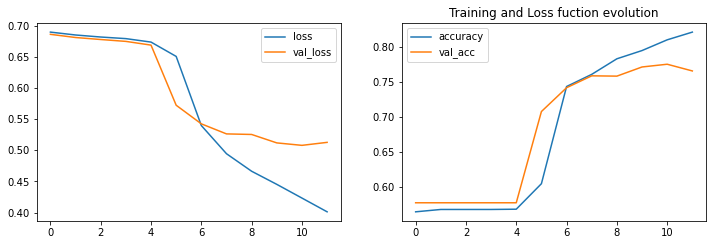

In [49]:
model = Model(i, x)
optimizer = Adam(learning_rate=1e-5)
# Compile and fit
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
r = model.fit(data_train, y_train, epochs=15, 
              validation_data=(data_test, y_test), 
              batch_size=1, callbacks=[es])
evaluate(model, data_train, data_test, y_train, y_test)
plot_loss_evaluation(r)

In [50]:
sequences_test = tokenizer.texts_to_sequences(test.text)
data_test = pad_sequences(sequences_test, maxlen=data_train.shape[1])
print(f"Found {len(tokenizer.word_index)} unique tokens.")
print(f"Testing Data shape: {data_test.shape}")

Found 14442 unique tokens.
Testing Data shape: (3263, 31)


In [52]:
sample_submission=pd.read_csv('../input/nlp-getting-started/sample_submission.csv')
y_pre = model.predict(data_test)
y_pre = np.round(y_pre).astype(int).reshape(3263)
sub = pd.DataFrame({'id':sample_submission['id'].values.tolist(), 'target':y_pre})
sub.to_csv('submission.csv', index=False)
sub.head()

,id,target
0,0,0
1,2,0
2,3,1
3,9,0
4,11,1
